## Accessing MTBS data with the Planetary Computer STAC API

This notebook provides an example of accessing Monitoring Trends in Burn Severity (MTBS) Mosiacs for CONUS and Alaska using the Planetary Computer API. The data is stored in annual cloud optimized GeoTIFF files.

Complete documentation for this dataset is available on the [Planetary Computer data catalog](https://planetarycomputer.microsoft.com/dataset/mtbs).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
import pystac_client
from pystac.extensions.projection import ProjectionExtension as proj
from shapely.geometry import shape
from shapely.ops import transform

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import planetary_computer
import pyproj
import rioxarray

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

The MTBS data on Azure is available for the CONUS or Alaska regions on an annual basis from 1984 to 2018. Let's query the Planetary Computer to find data items within the `mbts` collection.

In [3]:
carr_fire_aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.73925781250001, 40.50857873259441],
            [-122.33139038085936, 40.50857873259441],
            [-122.33139038085936, 40.891715295571046],
            [-122.73925781250001, 40.891715295571046],
            [-122.73925781250001, 40.50857873259441],
        ]
    ],
}

In [4]:
search = catalog.search(collections=["mtbs"], intersects=carr_fire_aoi)
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 35 Items


While only reading metadata from the STAC API response we can check the footprint shape of this data, and what assets it contains. Based on the size, we'll want to only read a subsection of the underlying file. 

In [5]:
item = items[0]
print("Footprint shape:", proj.ext(item).shape)
print("Assets:", ", ".join(item.assets))

Footprint shape: [70357, 69612]
Assets: metadata, burn-severity


### Read item asset with xarray

Open the asset file on blob storage using `rioxarray`. We'll select the data asset `burn-severity` which has the URL for the underlying GeoTIFF.

In [6]:
da = rioxarray.open_rasterio(
    item.assets["burn-severity"].href, chunks={"x": 2560, "y": 2560}
).squeeze()
da

<xarray.DataArray (y: 70357, x: 69612)>
dask.array<getitem, shape=(70357, 69612), dtype=uint8, chunksize=(2560, 2560), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 -2.298e+06 -2.298e+06 ... -2.102e+05 -2.101e+05
  * y            (y) float64 3.096e+06 3.096e+06 ... 9.854e+05 9.854e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

### Plot one fire event

We can select a subset of the data to make a plot over our single fire event. To select from the larger DataArray, we'll transform our original GeoJSON area of iterest to the CRS of the dataset and use the bounds to slice the array.

In [7]:
%%time
aoi_poly = shape(carr_fire_aoi)
from_crs = pyproj.CRS("EPSG:4326")

project = pyproj.Transformer.from_crs(from_crs, da.rio.crs, always_xy=True).transform
utm_poly = transform(project, aoi_poly)
minx, miny, maxx, maxy = utm_poly.bounds

fire_da = da.sel(y=slice(maxy, miny), x=slice(minx, maxx))

CPU times: user 54.6 ms, sys: 12.6 ms, total: 67.2 ms
Wall time: 65.4 ms


Up to this point, we haven't actually read any data yet, but by plotting we'll trigger the read and see out results.

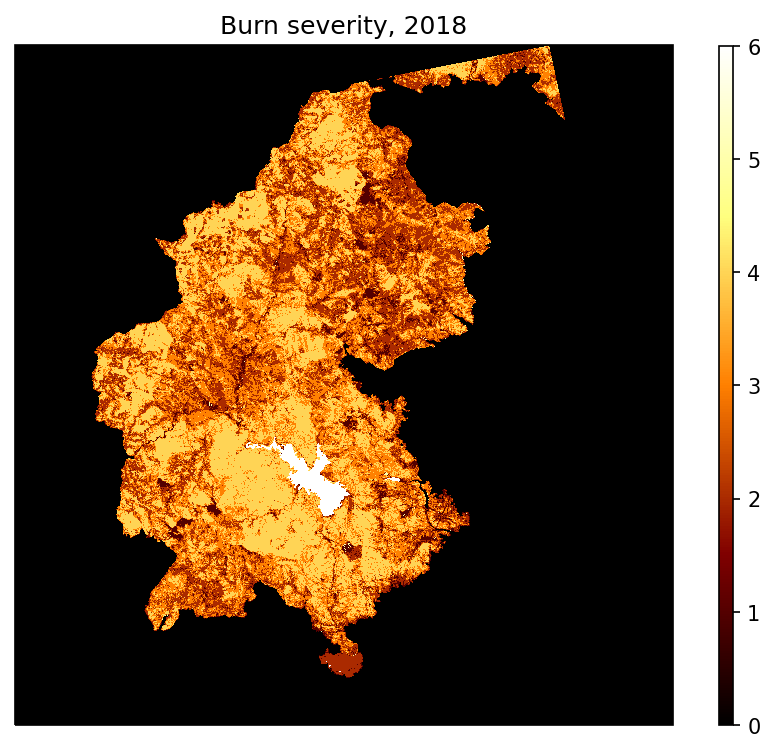

In [8]:
fig, ax = plt.subplots(
    figsize=(8, 6),
    dpi=150,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    frameon=False,
)
ax.patch.set_facecolor("black")
fire_da.plot(
    ax=ax, transform=ccrs.AlbersEqualArea(), cbar_kwargs={"aspect": 50}, cmap="afmhot"
)
plt.title("Burn severity, 2018")
plt.show()